# Main goal: 
- Hani is looking for the final list of genes which are drug induced significantly methylated, expressed and stabilized. 

    ○ Venn diagram 

    ○ UpsetR 

=> table of these genes with all logFCs, pvalues and screening scores. 


In [219]:
# cp -v radar/result.all.txt hl60_delta_mtyl_table.txt

In [1]:
import pandas as pd 
import numpy as np
# Teated vs. non-treated 
comparisons = [
    # HL-60 meRIP-seq - logFC
    'meRIP-seq/hl60_delta_mtyl_table.txt' ,
    # HL-60 Ribo-seq - lnTE
    'Ribo-seq/hl60_delta_te_table.txt' ,
    # HL-60 RNA-seq 
    # RNA experssion - log2FC
    'RNA-seq/hl60-exp/hl60_delta_exp_table.txt',
    # RNA stability  - logFC
    'RNA-seq/hl60-stbl/hl60_delta_stbl_table.txt',
    ## 5 other AML cell lines RNA-seq
    # RNA experssion - log2FC
    'RNA-seq/other-exp/kg1_delta_exp_table.txt', 'RNA-seq/other-exp/molm14_delta_exp_table.txt',
    'RNA-seq/other-exp/ociaml2_delta_exp_table.txt', 'RNA-seq/other-exp/ociaml3_delta_exp_table.txt',
    'RNA-seq/other-exp/thp1_delta_exp_table.txt',
    # RNA stability - logFC
    'RNA-seq/other-stbl/kg1_delta_stbl_table.txt', 'RNA-seq/other-stbl/molm14_delta_stbl_table.txt',
    'RNA-seq/other-stbl/ociaml2_delta_stbl_table.txt', 'RNA-seq/other-stbl/ociaml3_delta_stbl_table.txt',
    'RNA-seq/other-stbl/thp1_delta_stbl_table.txt'
]


# extract cell line name experiment name 
names = [c.split('/')[-1].replace('.txt','').replace('_table','') for c in comparisons]
tables = [pd.read_csv(x, sep = '\t') for x in comparisons]
cells = [names[i].split('_')[0] for i,x in enumerate(comparisons)]
experiments = [names[i].replace(cells[i]+'_', '') for i,x in enumerate(comparisons)]

# read data into Pandas Data.Frames 
Data = dict(((c,{}) for c in cells))
for i,x in enumerate(comparisons): 
    cel = cells[i]
    exp = experiments[i]
    # read data and write into dictionary 
    Data [cel][exp] = tables[i]

Data['hl60']['delta_te'] = Data['hl60']['delta_te'][['gene_id','gene_name','Estimate_treatmentDRUG','fdr_Pr...z.._treatmentDRUG']]
Data['hl60']['delta_mtyl'] = Data['hl60']['delta_mtyl'][['ensembl','name','logFC','p_value']]
Data['hl60']['delta_mtyl'].columns = ['gene_id','gene_name','logFC','pval']

Let's include CRISPR screening scores 

In [2]:
def make_score_df(screen, score, rep='ave_Rep1_Rep2'):
    '''
    Make dataframe for given score from CRISPR screening Excel file 
    '''

    score_cols = [i for i,c in enumerate(screen.columns) if score in c]
    # extract screen informations from Excel file 
    screen_info = list(zip(
        score_cols,
        screen.iloc[0, score_cols].tolist(), 
        screen.iloc[1, score_cols].tolist(), 
        screen.columns[score_cols].tolist() 
    ))
    
    # select columns for given score
    cols = [c[0] for c in screen_info if c[1] == rep]
    # remove top 3 rows 
    df = screen.iloc[3:,cols]

    # set DataFrame column names from row 1
    df.columns = screen.iloc[1,cols].tolist()
    # add gene_name column
    gene_names = [str(g) for g in screen.iloc[3:,0]]
    df.insert (0, "gene_name", [g for g,t in zip(gene_names,df.transcripts)])
    # select rows with gene names  
    df = df.iloc[[i for i,g in enumerate(df.gene_name) if 'pseudo_' not in g],:].reset_index(drop=True)

    # only keep one transcript name
    df.transcripts = [str(g).split(',')[0] for g in df.transcripts]    
    # rename phenotype score column to the score name
    df.columns = [score + ' score' if x=='average phenotype of strongest 3' else x for x in df.columns]
    
    print (df.shape)
    return df

In [3]:
screen = pd.read_excel('screen/CRISPRi_HL60_DAC_genetable_collapsed.xlsx')

Data['hl60']['rho'] = make_score_df(screen, 'rho')
Data['hl60']['gamma'] = make_score_df(screen, 'gamma')

(18905, 6)
(18905, 6)


# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

In [4]:
Top = {}

In [5]:
def find_top(
    df,
    value, value_thr, stat, stat_thr,
    n_line=None, drop_dup=False):
    
    # Select rows (genes) which has value >= value_thr & stat < stat_thr 
    if n_line==None:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        
    # found in more than n_line cell lines 
    else:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line]
                ).all(axis=0)) if l == 1]
                ,:]
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line,]
                ).all(axis=0)) if l == 1]
                ,:] 
        
    if drop_dup==True:
        up = up.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
        dn = dn.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
    
    print ('up: ', up.shape[0])
    print ('down:', dn.shape[0])

    return up, dn


## Translational efficiency

In [6]:
def set_Top_TE(te_thr,fdr_thr):
    print ('Subset Top TE data frame:')
    Top['TE'] = {}
    Top['TE']['threshold'] = [['te_thr',te_thr],['fdr_thr',fdr_thr]]

    Top['TE']['up'], Top['TE']['down'] = find_top(
        Data['hl60']['delta_te'], 'Estimate_treatmentDRUG', te_thr, 'fdr_Pr...z.._treatmentDRUG', fdr_thr
    )


## $\Delta$RNA methylation

In [7]:
def set_Top_Mtyl(fc_thr,pv_thr):
    print ('Subset Top Mtyl data frame:')
    
    Top['Mtyl'] = {}
    Top['Mtyl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]
    Top['Mtyl']['up'], Top['Mtyl']['down'] = find_top(
        Data['hl60']['delta_mtyl'], 
        'logFC', fc_thr, 'pval', pv_thr, drop_dup=True)

## $\Delta$RNA expression 

Extract experssion data for 6 AML cell lines:

In [8]:
E_gene_names = Data['hl60']['delta_exp'].set_index('gene_id')[['gene_name']]
E1 = Data['hl60']['delta_exp'].set_index('gene_id')[['log2FC_120h','pval_120h']].add_prefix('hl60.')
E2, E3, E4, E5, E6 = [
    Data[cell_line]['delta_exp'].set_index('gene_id').loc[
        E1.index,
        ['log2FoldChange','pvalue']].rename(columns={'log2FoldChange':'log2FC','pvalue':'pval'}
    ).add_prefix(cell_line+'.') for cell_line in Data if cell_line != 'hl60']

exp_df = pd.concat((E_gene_names, E1,E2,E3,E4,E5,E6),axis=1)

exp_df.to_csv('delta_expression.txt',sep='\t')

Define top genes in $\Delta$RNA expression data space: 
> genes with log2FC >= `fc_thr` and P-Value < `pv_thr` acrross `n_line` number of cell lines. 

In [9]:
def set_Top_Exp(fc_thr, pv_thr, n_line):
    print ('Subset Top Exp data frame:')

    Top['Exp'] = {}
    Top['Exp']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]
    Top['Exp']['up'], Top['Exp']['down'] = find_top(
        exp_df, 
        [c for c in exp_df.columns if 'log2FC' in c], fc_thr,
        [c for c in exp_df.columns if 'pval' in c], pv_thr,
        n_line=n_line
    )

## $\Delta$RNA stability

In [10]:
S_gene_names = Data['hl60']['delta_stbl'].set_index('ensembl_id')[['gene_name']]
S1 = Data['hl60']['delta_stbl'].set_index('ensembl_id')[['logFC_120h','P.Value_120h']].rename(columns={
    'logFC_120h':'logFC',
    'P.Value_120h':'pval'}).add_prefix('hl60.')
S2, S3, S4, S5, S6 = [
    Data[cell_line]['delta_stbl'].set_index('ensembl_id').loc[
        S1.index,
        ['logFC','P.Value']].rename(columns={'P.Value':'pval'}).add_prefix(cell_line+'.') 
    for cell_line in Data if cell_line != 'hl60']

stbl_df = pd.concat((S_gene_names, S1,S2,S3,S4,S5,S6),axis=1)

stbl_df.to_csv('delta_stability.txt',sep='\t')

Define top genes in $\Delta$RNA stability data space: 
> genes with log2FC >= `fc_thr` and P-Value < `pv_thr` acrross `n_line` number of cell lines. 

In [11]:
def set_Top_Stbl(fc_thr, pv_thr, n_line):
    print ('Subset Top Stbl data frame:')

    Top['Stbl'] = {}
    Top['Stbl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]
    Top['Stbl']['up'], Top['Stbl']['down'] = find_top(
        stbl_df, 
        [c for c in stbl_df.columns if 'logFC' in c], fc_thr,
        [c for c in stbl_df.columns if 'pval' in c], pv_thr,
        n_line=n_line
    )

## $\Delta$ Phenotype 

In [12]:
def set_Top_Rho(sc_thr,pv_thr):
    print ('Subset Top Rho data frame:')

    Top['Rho'] = {}
    Top['Rho']['threshold'] = [['sc_thr',sc_thr],['pv_thr',pv_thr]]
    Top['Rho']['up'], Top['Rho']['down']  = find_top(
        Data['hl60']['rho'], 
        'rho score', sc_thr,'Mann-Whitney p-value', pv_thr)

# Plots

In [13]:
set_Top_TE  (0,1)
set_Top_Mtyl(0,1)
set_Top_Rho (0,1)
set_Top_Exp (0,1, 1)
set_Top_Stbl(0,1, 1)


Subset Top TE data frame:
up:  4103
down: 2206
Subset Top Mtyl data frame:
up:  7961
down: 8866
Subset Top Rho data frame:
up:  8935
down: 9894
Subset Top Exp data frame:
up:  42025
down: 40945
Subset Top Stbl data frame:
up:  2538
down: 2616


### Intersection of all genes across different datasets

### Venn diagram 

- https://python-graph-gallery.com/172-custom-venn-diagram/
- https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
- https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305


- https://anaconda.org/conda-forge/r-venn
- https://pypi.org/project/venn/

Select top gene names 

In [19]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Rho_up = Top['Rho']['up'].gene_name.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Rho_down = Top['Rho']['down'].gene_name.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

In [20]:
# Import the library
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def venn_diagram(a, b, c, labels=['A', 'B', 'C']):
    
    a = list(set(a))
    b = list(set(b))
    c = list(set(c))
    
    only_a = len( [x for x in a if x not in b+c] )
    only_b = len( [x for x in b if x not in a+c] )
    only_c = len( [x for x in c if x not in a+b] )

    a_b = len(np.intersect1d(a, b))
    a_c = len(np.intersect1d(a, c))
    b_c = len(np.intersect1d(b, c))
    
    a_b_c = len([ x for x in a if (x in b) and (x in c)])
    
    venn3(subsets=(only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)    
    
def iter_above_three(datasets, names):
    # unique permutations to chose 3 from the number of given datasets 
    iterations = list(itertools.combinations(list(range(len(datasets))), 3))
    # draw unique venn_diagrams
    for i,iteration in enumerate(iterations):
        p = plt.figure(i)
        a,b,c=[datasets[n] for n in iteration]
        venn_diagram(a,b,c,labels=[names[n] for n in iteration]
        )
        p.show()    

def iter_by_two(input1,input2,input3):
    # inputs are variable names 
    for n, comb in enumerate(list(itertools.product(input1,input2,input3))):
        a,b,c = comb
        p = plt.figure(n)
        venn_diagram(eval(a),eval(b),eval(c), [a,b,c])
        p.show()    

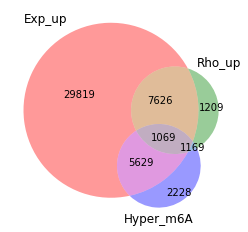

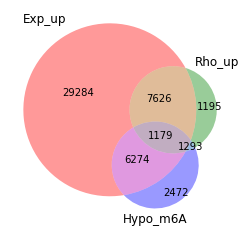

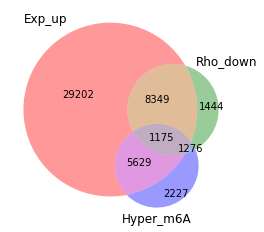

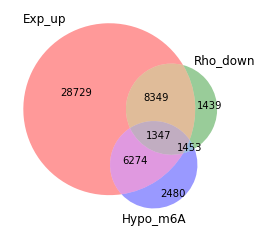

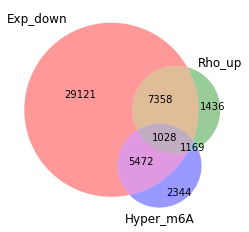

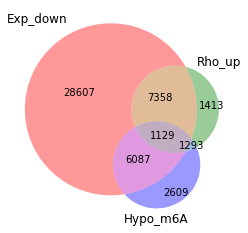

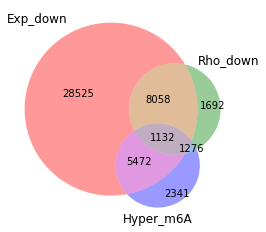

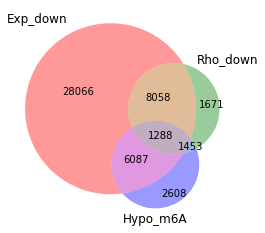

In [22]:
iter_by_two(['Exp_up', 'Exp_down'],['Rho_up', 'Rho_down'],['Hyper_m6A', 'Hypo_m6A'])

# Final merged table

In [23]:
%reload_ext rpy2.ipython

In [24]:
%%R 
suppressMessages(suppressWarnings(library (UpSetR)))
suppressMessages(suppressWarnings(library (gplots)))
suppressMessages(suppressWarnings(library (patchwork)))

In [25]:
%%R 
intersect <- function(Vecs, plot_upset=TRUE,plot_venn=FALSE){
    intersection <- Reduce(intersect,Vecs)
    if (plot_upset == TRUE){
        SET = upset(fromList(Vecs), order.by = "freq")
        print (SET)
    }
    if (plot_venn == TRUE){
        VEN = venn (Vecs)
        print (VEN)
    }
    return(intersection)
}

In [26]:
M_genes = list(set(Data['hl60']['delta_mtyl'].gene_name.tolist()))
T_genes = list(set(Data['hl60']['delta_te'].gene_name.tolist()))
R_genes = list(set(Data['hl60']['rho'].gene_name.tolist()))
S_genes = list(set(stbl_df.gene_name.tolist()))
E_genes = list(set(exp_df.gene_name.tolist()))

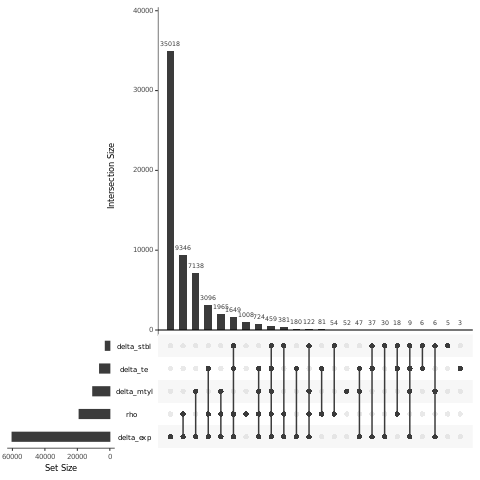

In [27]:
%%R -i M_genes,T_genes,R_genes,S_genes,E_genes -o A_genes

Vecs <- list(
    delta_mtyl = unlist(M_genes),
    delta_te = unlist(T_genes),
    rho = unlist(R_genes),
    delta_stbl = unlist(S_genes),
    delta_exp = unlist(E_genes)
)

A_genes = intersect(Vecs)

Use intersect genes names from UpSetR format ... 

In [28]:
def get_intersect_df(data,k=None,intersect_genes=A_genes):
    # change intersect_genes based on the biological question
    if k is not None: 
        df = data[k]
    else: 
        df = data
    
    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(intersect_genes)],]
    print (out.shape)
    return out

In [29]:
E = get_intersect_df(exp_df)
S = get_intersect_df(stbl_df)
M = get_intersect_df(Data['hl60'],'delta_mtyl')
T = get_intersect_df(Data['hl60'],'delta_te')
R = get_intersect_df(Data['hl60'],'rho')
G = get_intersect_df(Data['hl60'],'gamma')


(1, 13)
(0, 13)
(7, 4)
(0, 4)
(0, 6)
(0, 6)


In [30]:
final = pd.DataFrame(index=A_genes)

final = pd.concat([
    final,
    # Expression
    E.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Exp.'),
    # Stability 
    S.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Stbl.'),
    # Translational Efficiency 
    T.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('TE.'),
    # CRISPR Screen Rho score
    R.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Rho.'),
    # CRISPR Screen Gamma score
    G.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Gamma.')
    
],axis=1)
    
final.to_csv('combined.txt', sep='\t')

In [31]:
%%R 
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/down/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] patchwork_1.1.1 gplots_3.1.1    UpSetR_1.4.0   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6         magrittr_2.0.1     tidyselect_1.1.0   munsell_0.5.0     
 [5] colorspace_2.0-0   R6_2.5.0           rlang_0.4.10       plyr_1.8.6        
 [9] dplyr_1.0.3        caTools_